In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [4]:
train_path ='/content/drive/MyDrive/figuier maladies/training'
test_path = '/content/drive/MyDrive/figuier maladies/testing'
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(train_path, batch_size=30)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(test_path, batch_size=30)

Found 588 images belonging to 5 classes.
Found 118 images belonging to 5 classes.


Found 588 files belonging to 5 classes.
Found 118 files belonging to 5 classes.


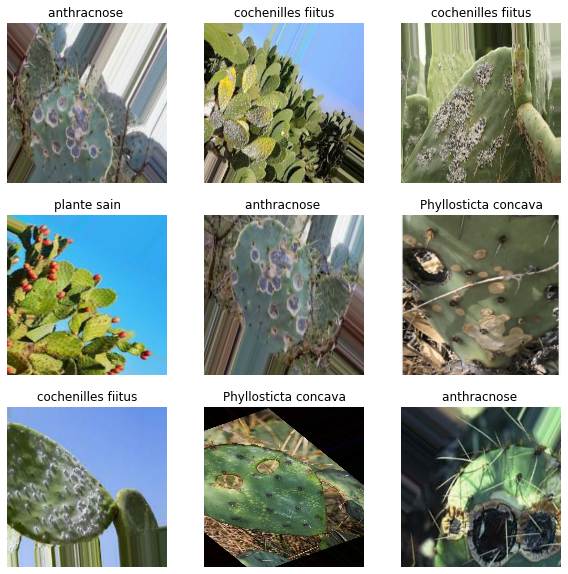

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# seulement pour l'affichage 
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
base_model = MobileNetV2(weights = 'imagenet', include_top = False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
preds= Dense(5, activation = 'softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [16]:
for layers in model.layers[:-5]:
    layers.trainable = False

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [18]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs = None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.model.reset_metrics()

In [19]:
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)

In [20]:
epochs = 20

optmizer = Adam(learning_rate=.0001)
model.compile(loss='categorical_crossentropy', optimizer=optmizer, metrics= "acc" )
batch_stats_callback = CollectBatchStats()

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    verbose=1,
    validation_data = test_generator,
    validation_steps = validation_steps,
)

Epoch 1/20
20/20 [==============================] - 89s 4s/step - loss: 1.3144 - acc: 0.4541 - val_loss: 1.1440 - val_acc: 0.4576
Epoch 2/20
20/20 [==============================] - 31s 2s/step - loss: 0.8341 - acc: 0.7381 - val_loss: 0.7783 - val_acc: 0.7712
Epoch 3/20
20/20 [==============================] - 30s 2s/step - loss: 0.5203 - acc: 0.8673 - val_loss: 0.5408 - val_acc: 0.8390
Epoch 4/20
20/20 [==============================] - 30s 2s/step - loss: 0.3022 - acc: 0.9456 - val_loss: 0.3649 - val_acc: 0.8983
Epoch 5/20
20/20 [==============================] - 30s 2s/step - loss: 0.1805 - acc: 0.9711 - val_loss: 0.2703 - val_acc: 0.9153
Epoch 6/20
20/20 [==============================] - 36s 2s/step - loss: 0.1164 - acc: 0.9830 - val_loss: 0.2243 - val_acc: 0.9322
Epoch 7/20
20/20 [==============================] - 31s 2s/step - loss: 0.0773 - acc: 0.9915 - val_loss: 0.1822 - val_acc: 0.9322
Epoch 8/20
20/20 [==============================] - 36s 2s/step - loss: 0.0553 - acc: 0.99

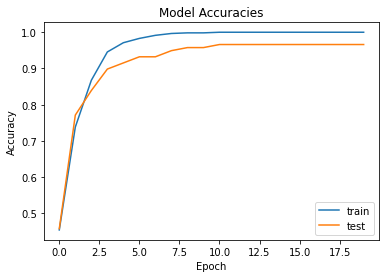

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

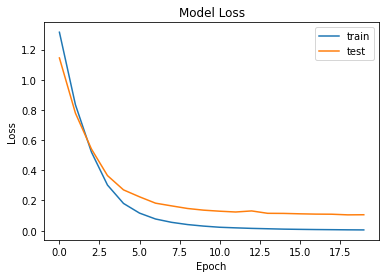

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [27]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches)
validation_dataset = validation_dataset.skip(val_batches )

In [28]:
# We have our neural network trained with tensorflow and keras, we can export it 

saved_model_dir = '/content/drive/MyDrive/figuier maladies/' #means current directory

tf.saved_model.save(model, saved_model_dir) #saves to the current directory

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning

with open('model.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/figuier maladies/assets
